# TLDR

Let's see how IPF converges as we change the number and makeup of the suppressions.

# Dependencies

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)    
plt.rc('legend', fontsize=SMALL_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE, figsize=(15,8)) 

# Library

Here are some parameters/constants for the exercise:

In [31]:
RANGE = (1, 1000)
SIZE = (100,100)
CONVERGENCE_THRESHOLD = 1e-3
MAX_ITERATIONS = 50000

And here are the library functions that do all the heavy lifting:

In [45]:
class TestData:
    """A datatype for all the inputs we need to perform a test"""
    
    def __init__(self, 
                 suppressed_data: np.ndarray, 
                 mask: np.ndarray, 
                 row_totals: np.ndarray,
                 column_totals: np.ndarray):
        self.suppressed_data = suppressed_data
        self.mask = mask
        self.row_totals = row_totals
        self.column_totals = column_totals

        
def get_suppression_mask(data: np.ndarray, number_of_suppressions: int) -> np.ndarray:
    """Randomly choose number_of_suppressions cells to suppress, and return a mask of the suppressions."""
    
    rows, columns = data.shape
    mask = np.array([[False] * columns] * rows)
    assert(mask.shape == data.shape)
    
    for i in range(number_of_suppressions):
        success = False
        
        while not success:
            row = random.randint(0, rows-1)
            col = random.randint(0, columns-1)
            
            if not mask[row, col]:
                mask[row, col] = True
                success = True
                
    return mask

def suppress_data(data: np.ndarray, number_of_suppressions:int) -> TestData:
    """Replace number_of_suppressions cells with random numbers.
    """
    mask = get_suppression_mask(data, number_of_suppressions)
    
    suppressed = data.copy()
    suppressed[mask] = np.rint(np.random.uniform(low=RANGE[0], high=RANGE[1], size=[number_of_suppressions]))
    
    column_totals = np.sum(original_data, axis=0)
    row_totals = np.sum(original_data, axis=1)

    return TestData(suppressed, mask, row_totals, column_totals)


def ipf(data: TestData) -> int:
    """Perform IPF and return the number of iterations"""
    
    suppressed_data = data.suppressed_data.copy()
    mask = data.mask
    row_totals = data.row_totals
    column_totals = data.column_totals
    
    delta = CONVERGENCE_THRESHOLD + 1
    i = 0

    while delta > CONVERGENCE_THRESHOLD and i < MAX_ITERATIONS:
        before = suppressed_data[mask]
    
        current_row_totals = np.sum(suppressed_data, axis=1)
        current_column_totals = np.sum(suppressed_data, axis=0)

        for row in range(SIZE[0]):
            missing_indexes = mask[row, :]    
            suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] / current_row_totals[row] 
            suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] * row_totals[row]

        for col in range(SIZE[1]):
            missing_indexes = mask[:, col]    
            suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] / current_column_totals[col] 
            suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] * column_totals[col]    

        after = suppressed_data[mask]
        delta = np.sum(np.abs(after-before))
        i += 1

    return i

# Convergence Test

In [62]:
MAX_SUPPRESSIONS = 100

original_data = np.rint(np.random.uniform(low=RANGE[0], high=RANGE[1], size=SIZE))

iterations = []
for i in range(1, MAX_SUPPRESSIONS+1):
    test_data = suppress_data(original_data, i)
    iterations.append([i, ipf(test_data)])


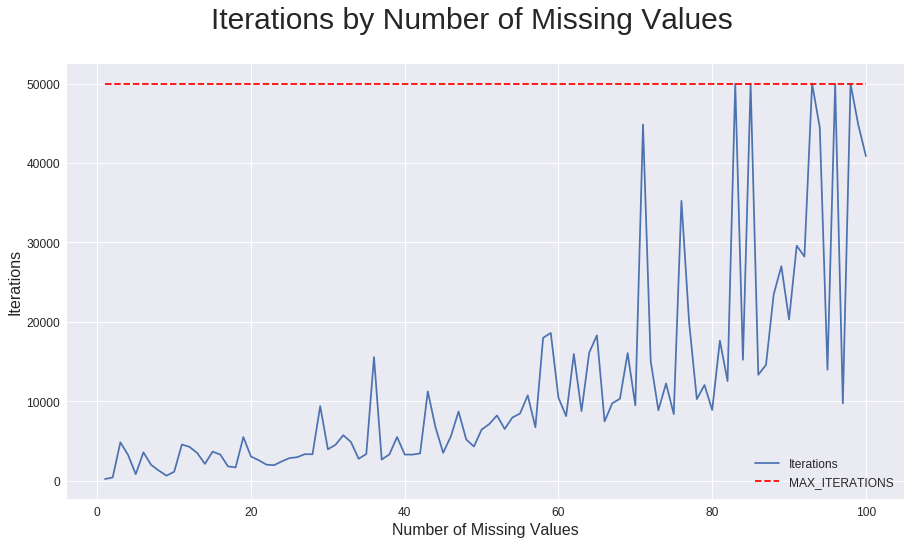

In [74]:
iterations = np.array(iterations)
ax = plt.plot(iterations[:,0], iterations[:,1], '',
              iterations[:,0], [MAX_ITERATIONS] * len(iterations), 'r--'
             ) 
plt.legend(["Iterations", "MAX_ITERATIONS"])
plt.suptitle("Iterations by Number of Missing Values")
plt.ylabel("Iterations")
plt.xlabel("Number of Missing Values")
plt.show()